In [1]:
import pandas as pd
import numpy as np
import torch
import importlib
from utils.utils_dataset import prepare_k_fold_non_iid_dataset, plot_dataset_split, display_dataset_split
from sklearn import datasets
from sklearn.model_selection import KFold
from utils.utils_train import train_supervised, train_unsupervised, calculate_metrics_statistics, format_metrics, calculate_cluster_stats
from utils.utils_plots import plot_first_feature, plot_first_feature_horizontal, save_figure
from utils.utils_train import test_model   

In [2]:
from model.eGauss_plus import eGAUSSp

# Model parameters
local_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.0,
    "S_0": 1e-8,
    "c_max": 4,
    "device": torch.device("cpu")
}
federated_model_params = {
    "feature_dim": 4,
    "num_classes": 3,
    "N_max": 1,
    "num_sigma": 2,
    "kappa_join": 1.5,
    "S_0": 1e-8,
    "c_max": 2,
    "device": torch.device("cpu")
}


*** Start of fold 0. ***

Training model for client 1
Evolving has been enabled.
Processed 19 points.Number of clusters: 9

Testing model for client 1
Evolving has been disabled.
Test Metrics: {'accuracy': 0.6, 'precision': 0.8285714285714286, 'recall': 0.6, 'f1_score': 0.5493779904306221}
Number of clusters with multiple samples for Client 1 = 3

Training model for client 2
Evolving has been enabled.
Processed 31 points.Number of clusters: 5

Testing model for client 2
Evolving has been disabled.
Test Metrics: {'accuracy': 0.7, 'precision': 0.8350000000000001, 'recall': 0.7, 'f1_score': 0.5935483870967742}
Number of clusters with multiple samples for Client 2 = 2

Training model for client 3
Evolving has been enabled.
Processed 40 points.Number of clusters: 8

Testing model for client 3
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9, 'precision': 0.9214285714285714, 'recall': 0.9, 'f1_score': 0.896}
Number of clusters with multiple samples for Client 3 = 5

Training model

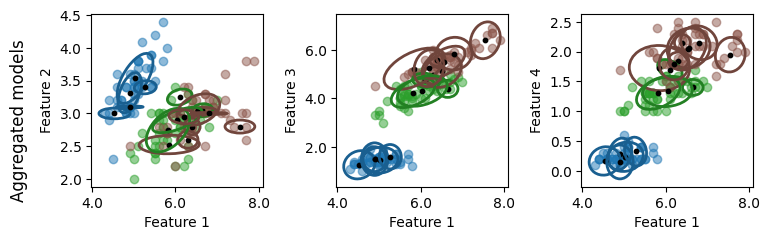

Figure saved as Images/iris_federated_pre_merge.svg in svg format.
Figure saved as Images/iris_federated_pre_merge.pdf in pdf format.
Number of clusters after transfer = 17

Testing federated model
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9333333333333333, 'precision': 0.9435897435897436, 'recall': 0.9333333333333333, 'f1_score': 0.933080808080808}


In [3]:
# Load the Iris dataset
iris = datasets.load_iris()

X = iris.data
y = iris.target

num_clients = 4
num_splits = 5

kf = KFold(n_splits=num_splits, shuffle=True, random_state=None)  

# Initialize arrays to track samples per class for each client in each fold
samples_per_class_per_client = np.zeros((num_clients, local_model_params["num_classes"], num_splits))

# Main loop for k-fold cross-validation
all_client_metrics = [[] for _ in range(num_clients)]
all_client_clusters = [[] for _ in range(num_clients)]

all_federated_metrics = []
all_federated_clusters = []

for i_fold, (train_index, test_index) in enumerate(kf.split(iris.data)):
    print(f"\n*** Start of fold {i_fold}. ***")
    
    #Split the data
    train_data, test_data, all_data = prepare_k_fold_non_iid_dataset(X, y, train_index, test_index, num_clients)
    
    #Create the models
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)

    #Train the models
    for client_idx, client_model in enumerate(local_models):
        
        # Count the number of samples per class for this client in this fold
        for class_idx in range(client_model.num_classes):
            class_samples = torch.sum(train_data[client_idx][1] == class_idx)
            samples_per_class_per_client[client_idx, class_idx, i_fold] = class_samples

        #Supervised clustering
        print(f"\nTraining model for client {client_idx + 1}")
        train_supervised(client_model, train_data[client_idx]) 

        #Test the local models
        print(f"\nTesting model for client {client_idx + 1}")
        metrics = test_model(client_model, test_data)
        print(f"Test Metrics: {metrics}")
        all_client_metrics[client_idx].append(metrics)

        #Save the number of clusters
        num_client_clusters = torch.sum(client_model.n[:client_model.c] > 1).item()
        print(f"Number of clusters with multiple samples for Client {client_idx + 1} = {num_client_clusters}")
        all_client_clusters[client_idx].append(num_client_clusters)

    #Aggregate local models
    for client_model in local_models:
        federated_model.federal_agent.merge_model_privately(client_model, 1)
        
    #Plot the Aggregated model
    if i_fold == (num_splits-1):
        fig = plot_first_feature_horizontal(all_data, model=federated_model, num_sigma=2, N_max=0, title="Aggregated models")   
        save_figure(fig, "Images/iris_federated_pre_merge.svg","svg")
        save_figure(fig, "Images/iris_federated_pre_merge.pdf","pdf")


    #Merge the federated model clusters
    print(f"Number of clusters after transfer = {federated_model.c}")
    federated_model.federal_agent.federated_merging()
    num_federated_clusters = torch.sum(federated_model.n[:federated_model.c] > 1).item()

    #Test the federated model
    print(f"\nTesting federated model")
    federated_metrics = test_model(federated_model, test_data)
    print(f"Test Metrics: {federated_metrics}")
    all_federated_metrics.append(federated_metrics)
    all_federated_clusters.append(num_federated_clusters)


In [4]:
# Calculate the average samples per class for each client
average_samples_per_class_per_client = np.mean(samples_per_class_per_client, axis=2)
print("Average samples per class for each client:")
print(average_samples_per_class_per_client)

# At the end of all folds, calculate and format mean and standard deviation
# Compute and print metrics for each client
for client_idx, client_metrics in enumerate(all_client_metrics):
    formatted_metrics = calculate_metrics_statistics(client_metrics)
    
    print(f"\nMetrics for Client {client_idx + 1} (mean ± std):")
    for metric, value in formatted_metrics.items():
        print(f"{metric}: {value}")

#Calculate evaluation metrics for the federated model
avg_std_federated_metrics = calculate_metrics_statistics(all_federated_metrics)

print("\nFederated Model - Metrics (mean ± std):")
for metric, value in avg_std_federated_metrics.items():
    print(f"{metric}: {value}")

# Compute and print cluster stats for each client and federated model
for client_idx, client_clusters in enumerate(all_client_clusters):
    avg_clusters, std_clusters = calculate_cluster_stats(client_clusters)
    print(f"\nClient {client_idx + 1} - Average Number of Clusters (mean ± std): {avg_clusters:.2f} ± {std_clusters:.2f}")

# Compute and print cluster stats for the federated model
avg_fed_clusters, std_fed_clusters = calculate_cluster_stats(all_federated_clusters)
print(f"\nFederated Model - Average Number of Clusters (mean ± std): {avg_fed_clusters:.2f} ± {std_fed_clusters:.2f}")


Average samples per class for each client:
[[ 0.  11.   8.8]
 [19.8  0.  11. ]
 [10.2 17.8 11.4]
 [10.  11.2  8.8]]

Metrics for Client 1 (mean ± std):
accuracy: 0.71 ± 0.12
precision: 0.84 ± 0.05
recall: 0.71 ± 0.12
f1_score: 0.68 ± 0.14

Metrics for Client 2 (mean ± std):
accuracy: 0.67 ± 0.07
precision: 0.84 ± 0.02
recall: 0.67 ± 0.07
f1_score: 0.56 ± 0.08

Metrics for Client 3 (mean ± std):
accuracy: 0.92 ± 0.05
precision: 0.93 ± 0.05
recall: 0.92 ± 0.05
f1_score: 0.92 ± 0.05

Metrics for Client 4 (mean ± std):
accuracy: 0.89 ± 0.05
precision: 0.90 ± 0.05
recall: 0.89 ± 0.05
f1_score: 0.89 ± 0.05

Federated Model - Metrics (mean ± std):
accuracy: 0.88 ± 0.15
precision: 0.92 ± 0.09
recall: 0.88 ± 0.15
f1_score: 0.86 ± 0.19

Client 1 - Average Number of Clusters (mean ± std): 3.40 ± 0.55

Client 2 - Average Number of Clusters (mean ± std): 2.20 ± 0.45

Client 3 - Average Number of Clusters (mean ± std): 3.80 ± 0.84

Client 4 - Average Number of Clusters (mean ± std): 5.00 ± 1.22

Fed

Client 1: {1: 6, 2: 9}
Client 2: {0: 25, 2: 10}
Client 3: {0: 8, 1: 20, 2: 12}
Client 4: {0: 10, 1: 12, 2: 8}
Test Set: {0: 7, 1: 12, 2: 11}

Combined Number of Samples per Class:
Class 0: 50 samples
Class 1: 50 samples
Class 2: 50 samples

Total Number of Samples Across All Datasets: 150
Figure saved as Images/iris_data_distribution.svg in svg format.


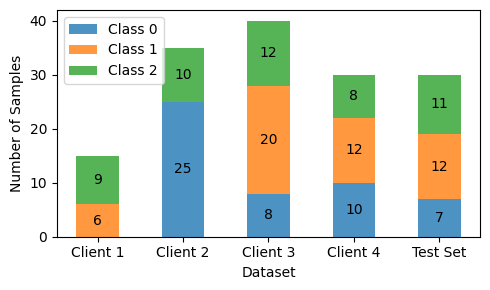

In [5]:
#Aditional plots of the data
display_dataset_split(train_data, test_data)
fig = plot_dataset_split(train_data, test_data)
save_figure(fig, "Images/iris_data_distribution.svg","svg")

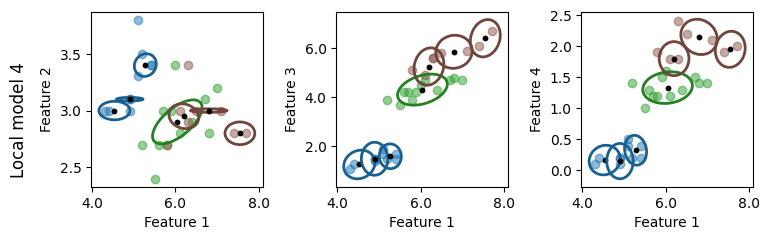

Figure saved as Images/iris_local_model.svg in svg format.
Figure saved as Images/iris_local_model.pdf in pdf format.


In [6]:
#Plot of the last local model
fig = plot_first_feature_horizontal(train_data[client_idx], model=client_model, num_sigma=2, N_max=1, title="Local model 4")  
save_figure(fig, "Images/iris_local_model.svg", "svg")
save_figure(fig, "Images/iris_local_model.pdf","pdf")

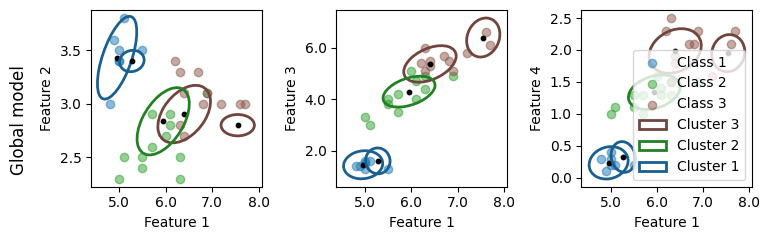

Number of clusters after merging = 5
Figure saved as Images/iris_federated_merged.svg in svg format.
Figure saved as Images/iris_federated_merged.pdf in pdf format.


In [7]:
#Plot of the last federated model
fig = plot_first_feature_horizontal(test_data, model=federated_model, num_sigma=2, N_max=0, title="Global model", legend=True)   
print(f"Number of clusters after merging = {federated_model.c}")
save_figure(fig, "Images/iris_federated_merged.svg","svg")
save_figure(fig, "Images/iris_federated_merged.pdf","pdf")